#WordNet Extractor
Extract Definitions, examples and words from WordNet, for a given set of seed words

####Libraries to import

In [ ]:
import pandas as pd
import numpy as np
import nltk
#nltk.download('wordnet')
from nltk.corpus import wordnet as wn
import os
from urllib.request import Request, urlopen, URLError
from bs4 import BeautifulSoup
import json
from wordnik import *
import swifter
from tqdm import tqdm 
import matplotlib.pyplot as plt
import timeit

#### Global Params

In [ ]:
"""
Global Params
"""
#file structures 
rootdir = 'D:\HWU\F21MP'
datadir = 'data'
tqdm.pandas()
#access the key files
wordnikKey = open(rootdir + os.sep + "api_key\wordnik.key", "r").read()
wordrec = {
              "theme"       : ''
           ,  "parent_word" : ''
           ,  "confidence"  : ''
           ,  "synset_name" : ''
           ,  "lex"         : ''
           ,  "pos"         : ''
           ,  "source"      : 'wordnet' 
           ,  "ttype"       : ''
           ,  "text"        : ''
    }
wordlist = []
master_columns=['theme', 'parent_word', 'confidence', 'synset_name', 'lex', 'pos', 'text']
tdf = pd.DataFrame(columns=master_columns)
wa = pd.DataFrame(columns=master_columns) #workarea

####Subroutines

##### Extraction from other dictionaries

In [ ]:
def write_wordlist_to_file(theme, filename, reclist=wordlist):
  """
  append wordlist to dataframe and write it to file

  Input:
    df(pandas dataframe) 
    file(filename)
    reclist(list of word records)
  Output:
    new_df(pandas dataframe) after appending the records to dataframe df
  """
  if len(wa) > 0:
    my_theme = wa.theme[0]
  else:
     my_theme = theme
  if my_theme!=theme:
    wa = wa[0:0]
  if len(reclist) > 0:
    wa = wa.append(reclist)
    wa.to_csv(filename)
    print('**Checkpoint reached. List saved to ,', filename)
    print('List length = ', len(reclist))

In [ ]:
def get_examples_from_yourdictionary( word , elimit=5):
  """
  This method scraps examples from yourdictionary.com for the given word
  INPUT:
    word =word to be extracted
    elimit = max number of sentences
  OUTPUT:
    sentence_ = list of sentences
  """
  base_url = 'https://sentence.yourdictionary.com/'
  word = word.replace('_', '-')
  url = base_url + word
  req = Request(url)                   # grab web page
  sentences_ = []
  try:
        grab_page = urlopen(req).read()
  except URLError as e:
      if hasattr(e, 'reason'):
          print(word, e.reason)

      elif hasattr(e, 'code'):
        print('The server couldn\'t fulfill the request.')
        print('Error code: ', e.code)
  except exception as e2:
    print('yourdictionary Error code: ', e2.code, ': word :', word)
  else:
        web_page = BeautifulSoup(grab_page, 'html.parser') # read web page lines
        #print(web_page)
        divs = web_page.find_all("div", class_= "sentence component")
        if divs:
          for index, div in enumerate(divs):
            if index >= elimit: 
              break
            sentences_.append(div.get_text())
        else: 
          index = 0
          json_lines = web_page.find_all('script')
          for json_line in json_lines:
            json_line = json_line.decode(eventual_encoding="utf-8").replace('\\"','"')
            json_line = json_line.replace('\\\\\"', '')
            if 'sentences' in json_line:
              try:
                json_line = json_line.split('JSON.parse',1)[1]
                json_line = json_line[2:]
                json_line = json_line[:-12] 
                jsonData = json.loads(json_line)
                jsonData = jsonData['data']['data']['sentences']
              except Exception as e:
                print('yourdictionary.com: Error extracting examples for :', word)
              else:
                for sentence in jsonData:
                  sentences_.append(sentence['sentence'])   
                  index = index + 1
                  if index >= elimit:
                    return sentences_
  return sentences_

In [ ]:
def get_examples_from_wordnik( word, elimit=5):
  """
  This gets examples for wordnik.
  INPUT: word = word for which example needs to be extracted
         elimit = max limit of examples to be extracted per word
  OUTPUT: sentences_ = list of sentences
  """
  sentences_ = []
  apiUrl = 'http://api.wordnik.com/v4'
  client = swagger.ApiClient(wordnikKey, apiUrl)
  wordApi = WordApi.WordApi(client)
  try:
    examplesSet = wordApi.getExamples(word, limit= elimit, includeDuplicates=False)
  except URLError as e:
      if hasattr(e, 'reason'):
          print(word, e.reason)

      elif hasattr(e, 'code'):
        print('The server couldn\'t fulfill the request.')
        print('Error code: ', e.code)
  except Exception as e:
      if hasattr(e, 'reason'):
          print(word, e.reason)
      elif hasattr(e, 'code'):
        print('The server couldn\'t fulfill the request.')
        print('Error code: ', e.code)
      else:
        print('Error processing, word:', word)  
  else:
    sentences_ = [example.text for example in examplesSet.examples]
  return sentences_

In [ ]:
def get_examples_by_wordrec(method, df, filename, rec, reclist, save=True ):
  """
  Subroutine gets the examples from other dictionaries for a given word record(rec)
  and appends it to the recordlist(wordlist)
  Input:
    method
    df
    file
    rec
    reclist
    save (bool) - true makes file to save every 100 words
  """
  examples=[]
  theme = rec["theme"]
  parent_word = rec["parent_word"]
  lex = rec["lex"]
  pos = rec["pos"]
  synset = rec["synset_name"]
  confidence = rec["confidence"]
  words = rec["text"].split(',')
  if method=='wordnik':
    for word in words:
      examples.extend(get_examples_from_wordnik(word))
  elif method=='yourdictionary':
    for word in words:
      examples.extend(get_examples_from_yourdictionary(word))
    #examples = [get_examples_from_wordnik(word) for word in words]
  for example in examples:
    reclist.append({  
            "theme"          : theme
            ,  "parent_word" : parent_word
            ,  "synset_name" : synset
            ,  "confidence"  : confidence
            ,  "lex"         : lex
            ,  "pos"         : pos
            ,  "source"      : method
            ,  "ttype"       : 'example'
            ,  "text"        : example
      }) 
    if len(reclist) > 100:
      write_wordlist_to_file(theme, filename, reclist) #write to file at every 100th record
      reclist.clear()
  return reclist

In [ ]:
def extract_more_examples(theme, method, df, option=1):
  folder = rootdir + os.sep + datadir 
  filename = folder + os.sep + theme + '_examples_' + str(option)+'.csv'
  #columns=['theme', 'parent_word', 'confidence', 'synset_name', 'lex', 'pos', 'text']
  wordlist = []
  if option==1:
    temp = df[df['ttype']=='lemmas']
  else:
    temp =  df[ df['ttype']=='related']
  #symptoms.progress_apply(lambda row: get_example(method, row, wordlist), axis=1)
  df = pd.DataFrame(columns=master_columns)
  wordlist = temp.progress_apply(lambda row: get_examples_by_wordrec(method, df, filename, row, wordlist), axis=1)
  if len(wordlist) > 0:
    #end of processing
    print('cleaning up extraction for theme ', themes)
    df = write_wordlist_to_file(df, filename, reclist) #write to file
  return df

In [ ]:
def extract_examples(scheme, method, df):
  folder = rootdir + os.sep + datadir
  filename = folder + os.sep +'wn_themes_' + scheme + '_' + method+ '.csv'
  themes = df['theme'].unique()
  print('Extracting examples for words via ', method)
  for theme in themes:
    print('---|Processing theme:', theme)
    print('------|Lemmas')
    ndf = df[df['theme']== theme]
    ndf = ndf.append(extract_more_examples(theme, method, ndf, 1 ))
    ndf.to_csv(filename)
    print('--------|Checkpoint reached. DF saved to ,', filename)
    print('------|Related Words')
    ndf = ndf.append(extract_more_examples(theme, method, ndf, 2 ))
    print('--------|Checkpoint reached. DF saved to ,', filename)
    ndf.to_csv(filename)
  return df

In [ ]:
"""def extract_more_examples_and_save(theme, method, df, option=1):
  print('.....extracting more examples for theme ', theme, ' using method ', method, 'option:', str(option)) 
  return extract_more_examples(theme, method, df, option) """

"def extract_more_examples_and_save(theme, method, df, option=1):\n  print('.....extracting more examples for theme ', theme, ' using method ', method, 'option:', str(option)) \n  return extract_more_examples(theme, method, df, option) "

##### Methods for extraction from WordNet

In [ ]:
def extract_syn(synset, word, theme, confidence=0.50,):
  """
  Method to extract data from synset and return in a specified format
  INPUT : 
    synset = synset
    word = the parent word
    theme = theme
    confidence = the confidence level to be used when removing duplicate texts
  OUTPUT: extract = the dictionary containing all required info about a word
  """
  more_words = []
  for lemma in synset.lemmas(lang='eng'):
    related_forms = lemma.derivationally_related_forms()
    for forms in related_forms:
      if forms.name() not in more_words:
        more_words.append(forms.name())
    """pertainyms = lemma.pertainyms()
    for forms in pertainyms:
      if forms.name() not in more_words:
        more_words.append(forms.name())"""
  extract = { 
            "theme": theme,
            "parent_word": word, 
            "confidence": confidence,
            "words": synset.lemma_names(lang='eng'),
            "synset": synset.name(),
            "lex": synset.lexname(),
            "pos": synset.pos(),
            "domain": synset.topic_domains(),
            "definition":synset.definition(),
            "examples": synset.examples(),
            "related_words" : more_words
          }
  return extract

In [ ]:
def append_rec_to_list( rec=wordrec, reclist=wordlist):
  """
  Method to add a word record to record list
  INPUT: 
    rec = formatted extract (word record)
    reclist = the list
  """
  words = rec.get("words")
  word_count = len(words)
  if word_count > 1 :
    words = ','.join(words)
  elif word_count == 1:
    words = words[0]
  else:
    words = ''    
  related_words = rec.get("related_words")
  word_count = len(related_words)
  if word_count > 1 :
    related_words = ','.join(related_words)
  elif word_count == 1:
    related_words = related_words[0]
  else:
    related_words = '' 
  
  theme = rec.get("theme")
  parent_word = rec.get("parent_word")
  lex = rec.get("lex")
  pos = rec.get("pos")
  synset = rec.get("synset")
  confidence = rec["confidence"]
# append definition
  definition = rec.get("definition")
  if len(definition) > 0: 
    reclist.append({
              "theme"       :  theme
           ,  "parent_word" : parent_word
           ,  "confidence"  : confidence
           ,  "synset_name" : synset
           ,  "lex"         : lex
           ,  "pos"         : pos
           ,  "source"      : 'wordnet'
           ,  "ttype"       : 'definition'
           ,  "text"        : definition
    })
# append the words as text
  if len(words) > 0: 
    reclist.append({  
              "theme"       :  theme
           ,  "parent_word" : parent_word
           ,  "confidence"  : confidence
           ,  "synset_name" : synset
           ,  "lex"         : lex
           ,  "pos"         : pos
           ,  "source"      : 'wordnet'
           ,  "ttype"       : 'lemmas'
           ,  "text"        : words
    })

# append the related words as text
  if len(related_words) > 0: 
    reclist.append({                
            "theme"         :  theme
           ,  "parent_word" : parent_word
           ,  "confidence"  : confidence
           ,  "synset_name" : synset
           ,  "lex"         : lex
           ,  "pos"         : pos
           ,  "source"      : 'wordnet' 
           ,  "ttype"       : 'related'
           ,  "text"        : related_words
    })
        
  examples = rec.get("examples")
  if len(examples) !=0 :
    for example in examples:
      reclist.append({  
            "theme" :  theme
           ,  "parent_word" : parent_word
           ,  "synset_name" : synset
           ,  "confidence"  : confidence
           ,  "lex"         : lex
           ,  "pos"         : pos
           ,  "source"      : 'wordnet'
           ,  "ttype"       : 'example'
           ,  "text"        : example
      })
  else:
    example = ''
    reclist.append({  
          "theme" :  theme
          ,  "parent_word" : parent_word
          ,  "synset_name" : synset
          ,  "confidence"  : confidence
          ,  "lex"         : lex
          ,  "pos"         : pos
          ,  "source"      : 'wordnet'
          ,  "ttype"       : 'example'
          ,  "text"        : example
    })    

In [ ]:
def get_hyponyms(synset):
  """
  iterative function to get the hyponyms of a synset
  input: sysnet
  output: list of hyponyms up to last level in hierarchy
  """
  list1 = synset.hyponyms( )
  if len(list1)!=0:
    list2 = []
    for item in list1:
      list3 = get_hyponyms(item)
      if len(list3)!=0: 
        list2.extend(list3)
    if len(list2)!=0:    
      list1.extend(list2)
  return list1

In [ ]:
def get_list_for_word(theme, word, wordlist,):
  """
  extract synsets, examples, definitions, related wirds for a given word
  and append it to the wordlist
  INPUT:theme 
        word
        wordlist
  """
  if len(word) > 0:
    #print('word is :' , word)
    synsets = wn.synsets(word, lang='eng')
    related_words = []
    for synset in synsets:
      word_ = synset.name().rsplit('.')[0]
      if word == word_ :
        confidence = 1.00
      else: confidence = 0.70
      wordrec = extract_syn(synset, word_, theme, confidence )
      related_words = wordrec['related_words']
      append_rec_to_list( wordrec, wordlist)
      hyponyms = get_hyponyms(synset)
      for hyponym in hyponyms:
        wordrec = extract_syn(hyponym, hyponym.name().rsplit('.')[0], theme )
        append_rec_to_list( wordrec, wordlist)
      similars = synset.similar_tos()
      for similar in similars:
        wordrec = extract_syn(similar, similar.name().rsplit('.')[0], theme)
        append_rec_to_list( wordrec, wordlist)
        #[get_list_for_word(theme, word_, wordlist) for word_ in related_words if ( word_!=word and len(word_)>0 )]

In [ ]:
def get_list_for_theme(theme, wordSet, wordlist):
  """
  Extract a list of sentences for a set of words in a theme
  and append it to the wordlist
  INPUT: 
    theme(str)
    wordSet(str) - words separated by comma
    wordList(list)- the sentences list(global param)
  """
  _wordSet = wordSet.split(',')
  for _word in _wordSet:
      get_list_for_word(theme, _word, wordlist,)

In [ ]:
def load_seed_words( scheme ):
  """
  Load the seed words from file
  input: 
      scheme(int) - the scheme determines the file to load
                    if you have only one scheme, use 1.
   file structure:
        theme, [seed_word1, seedword2, seedword3,...,seedwordn]

  """
  folder = rootdir + os.sep + 'Data'
  filename = folder + os.sep +'seedwords_' + scheme + '.csv'
  return pd.read_csv(filename)

In [ ]:
def main( scheme ):
  """
  the main routine
  input :
    scheme(int) - the scheme determines the file to load
                  if you have only one scheme, use 1.
  """
  columns=['theme', 'parent_word', 'confidence', 'synset_name', 'lex', 'pos', 'text']
  df = pd.DataFrame(columns=columns)
  wordset = set()
  wordrec = { "theme": '',
              "parent_word": '', 
              "words": [],
              "synset": '',
              "lex": '',
              "pos": '',
              "domain": [],
              "definition":'',
              "examples": [],
              "similar_to": []
            }
  wordlist = []
  folder = rootdir + os.sep + datadir
  filename = folder + os.sep +'wn_themes_' + scheme + '.csv'
  wordlist = []
  themes = load_seed_words( scheme )
  themes = themes.dropna()
  print('Seedwords loaded.')
  print('Word count = ', len(themes))
  print('Theme count = ', themes['theme'].nunique())
  print('Starting WordNet extraction....')
  start = timeit.timeit()
  # generate the wordlist
  themes[['theme', 'words']].apply(lambda x: get_list_for_theme(*x, wordlist), axis=1)
  """df['col_3'] = df[['col_1','col_2']].apply(lambda x: f(*x), axis=1)
   for theme in themes:
    theme_name = theme.get("theme")
    for word in theme.get("words"):
      get_list_for_word(theme_name, word, wordlist, True)  """
  
  #save to disk
  df = df.append(wordlist)
  df = df.sort_values(by=['parent_word', 'text', 'confidence' ])
  df= df.drop_duplicates(['parent_word', 'text'],keep='last').sort_index()
  df = df.sort_values(by=['theme', 'text', 'confidence' ])
  df= df.drop_duplicates(['theme', 'text'],keep='last').sort_index()
  end = timeit.timeit()
  df.to_csv( filename )
  print('WordNet Extraction complete. Saved to file ,', filename)
  print('Time elapsed :', end-start)
  return df 

In [ ]:
def draw_plot(df):
  fig, ax = plt.subplots()
  fig.suptitle("Text Distribution", fontsize=12)
  df.theme.reset_index().groupby("theme").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
  for p in ax.patches:
    width = p.get_width()
    if width > 10000:
            ax.annotate(str(int(p.get_width())), (p.get_x() + p.get_width(), p.get_y()), xytext=(-2, 4), textcoords='offset points', horizontalalignment='right')
    else:
          ax.annotate(str(p.get_width()), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
  plt.show()

In [ ]:
def read_master_file(master_file):
  df=pd.read_csv(master_file)
  return df

##Extract

Seedwords loaded.
Word count =  8
Theme count =  8
Starting WordNet extraction....
WordNet Extraction complete. Saved to file , D:\HWU\F21MP\data\wn_themes_scheme2.csv
Time elapsed : -1.0599998859106563e-05


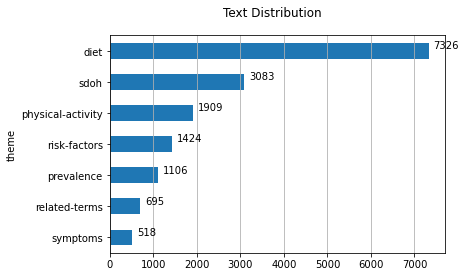

  0%|                                                                                          | 0/992 [00:00<?, ?it/s]

Extracting examples for words via  yourdictionary
---|Processing theme: sdoh
------|Lemmas


  1%|▊                                                                                | 10/992 [00:15<25:59,  1.59s/it]


UnboundLocalError: ignored

In [ ]:
if __name__== "__main__":
  scheme = 'scheme1' #@param ['scheme1', 'scheme2']
  tdf = main(scheme)
  tdf = tdf[tdf['theme']!='skip-terms']
  draw_plot(tdf)
# extracting additional examples
  method = 'yourdictionary' #@param ['wordnik', 'yourdictionary']
  ndf = extract_examples(scheme, method, tdf)
  nfile = rootdir + os.sep + datadir 
  nfile = nfile + os.sep + scheme + 'enh_extract.csv' 
  ndf.to_csv(nfile)
  draw_plot(ndf)

# Experiments and manual extraction

In [ ]:
get_examples_from_yourdictionary('run')

["I didn't run away.",
 'I could have run away from my father, as I wanted to.',
 "The child can't just run off across the country.",
 '"You\'re qualified to run the ranch," he said.',
 'Little calf does run and leap in field.']

In [ ]:
get_examples_from_wordnik('perspiration')

KeyboardInterrupt: ignored

Add more examples to symtoms

In [ ]:
#themes = tdf.theme.nunique( )
theme = 'symptoms' # ['risk-factors', 'related-terms','ssdoh', 'diet', 'symptoms', 'prevalence', 'physical-activity']


In [ ]:
theme = 'symptoms'
wordlist = extract_more_examples(theme, method)
columns=['theme', 'parent_word', 'confidence', 'synset_name', 'lex', 'pos', 'text']
ndf = pd.DataFrame(columns=columns)
ndf = ndf.append(wordlist)
examples_file =  rootdir + os.sep + 'data' + os.sep + method +'_'+ theme + scheme + '.csv'
ndf.to_csv(examples_file)
tdf = tdf.append(wordlist)
draw_plot(tdf)
full_file = rootdir + os.sep + 'data' + os.sep + 'wn_themes' + scheme + '_2.csv'
tdf.to_csv(full_file)

In [ ]:
wordlist = extract_more_examples_and_save('symptoms', method, option=2)
tdf = tdf.append(wordlist)
draw_plot(tdf)
full_file = rootdir + os.sep + 'data' + os.sep + 'wn_themes' + scheme + '_2.csv'
tdf.to_csv(full_file)

In [ ]:
draw_plot(tdf)

Add more examples to risk-factors

In [ ]:
theme = 'risk-factors'
wordlist = extract_more_examples(theme, method)
columns=['theme', 'parent_word', 'confidence', 'synset_name', 'lex', 'pos', 'text']
ndf = pd.DataFrame(columns=columns)
ndf = ndf.append(wordlist)
examples_file =  rootdir + os.sep + 'data' + os.sep + method +'_'+ theme + scheme + '.csv'
ndf.to_csv(examples_file)
tdf = tdf.append(wordlist)
draw_plot(tdf)
full_file = rootdir + os.sep + 'data' + os.sep + 'wn_themes' + scheme + '_2.csv'
tdf.to_csv(full_file)

In [ ]:
theme = 'risk-factors'
wordlist = extract_more_examples_and_save(theme, method, option=2)
tdf = tdf.append(wordlist)
draw_plot(tdf)
full_file = rootdir + os.sep + 'data' + os.sep + 'wn_themes' + scheme + '_2.csv'
tdf.to_csv(full_file)

Add more examples to related-terms

In [ ]:
theme = 'related-terms'
wordlist = extract_more_examples(theme, method)
columns=['theme', 'parent_word', 'confidence', 'synset_name', 'lex', 'pos', 'text']
ndf = pd.DataFrame(columns=columns)
ndf = ndf.append(wordlist)
examples_file =  rootdir + os.sep + 'data' + os.sep + method +'_'+ theme + scheme + '.csv'
ndf.to_csv(examples_file)
tdf = tdf.append(wordlist)
draw_plot(tdf)
full_file = rootdir + os.sep + 'data' + os.sep + 'wn_themes' + scheme + '_2.csv'
tdf.to_csv(full_file)

In [ ]:
theme = 'related-terms'
wordlist = extract_more_examples_and_save(theme, method, option=2)
tdf = tdf.append(wordlist)
draw_plot(tdf)
full_file = rootdir + os.sep + 'data' + os.sep + 'wn_themes' + scheme + '_2.csv'
tdf.to_csv(full_file)

Add more examples to prevalence

In [ ]:
theme = 'prevalence'
wordlist = extract_more_examples(theme, method)
columns=['theme', 'parent_word', 'confidence', 'synset_name', 'lex', 'pos', 'text']
ndf = pd.DataFrame(columns=columns)
ndf = ndf.append(wordlist)
examples_file =  rootdir + os.sep + 'data' + os.sep + method +'_'+ theme + scheme + '.csv'
ndf.to_csv(examples_file)
tdf = tdf.append(wordlist)
draw_plot(tdf)
full_file = rootdir + os.sep + 'data' + os.sep + 'wn_themes' + scheme + '_2.csv'
tdf.to_csv(full_file)

In [ ]:
theme = 'prevalence'
wordlist = extract_more_examples_and_save(theme, method, option=2)
tdf = tdf.append(wordlist)
draw_plot(tdf)
full_file = rootdir + os.sep + 'data' + os.sep + 'wn_themes' + scheme + '_2.csv'
tdf.to_csv(full_file)

Add more example to physical-activity

In [ ]:
full_file = rootdir + os.sep + 'data' + os.sep + 'wn_themes' + scheme + '_2.csv'
theme = 'physical-activity'
wordlist = extract_more_examples_and_save(theme, method, option=1)
tdf = tdf.append(wordlist)
tdf.to_csv(full_file)

In [ ]:
wordlist = extract_more_examples_and_save(theme, method, option=2)
tdf = tdf.append(wordlist)
tdf.to_csv(full_file)

In [ ]:
draw_plot(tdf)

Add more examples to sdoh

In [ ]:
full_file = rootdir + os.sep + 'data' + os.sep + 'wn_themes' + scheme + '_2.csv'
theme = 'sdoh'
wordlist = extract_more_examples_and_save(theme, method, option=1)
tdf = tdf.append(wordlist)
tdf.to_csv(full_file)

In [ ]:
wordlist = extract_more_examples_and_save(theme, method, option=2)
tdf = tdf.append(wordlist)
tdf.to_csv(full_file)

In [ ]:
draw_plot(tdf)

Add more examples to diet

In [ ]:
scheme = 'scheme2' #@param ['scheme1', 'scheme2']
full_file = rootdir + os.sep + 'data' + os.sep + 'wn_themes' + scheme + '_2.csv'
tdf = read_master_file(full_file)

In [ ]:
draw_plot(tdf)

In [ ]:
theme = 'diet'
len(tdf[(tdf['theme']== theme) & (tdf['ttype']=='related')])

In [ ]:
extract_more_examples_and_save('diet', method, tdf, full_file, 1)

In [ ]:
extract_more_examples_and_save('diet', method,tdf, full_file, option=2)

In [ ]:
draw_plot(tdf)

In [ ]:
print('number of lines from other sources = ', len(tdf[tdf['source']!='wordnet']))

In [ ]:
print('Number of texts which are missing are :', len(tdf[tdf.text =='']))

In [ ]:
tdf[tdf.theme=='symptoms']

In [ ]:
tdf

,theme,parent_word,confidence,synset_name,lex,pos,text,source,ttype
0,sdoh,life,0.7,life.n.02,noun.cognition,n,the experience of being alive; the course of h...,wordnet,definition
1,sdoh,life,0.7,life.n.02,noun.cognition,n,"life,living",wordnet,lemmas
3,sdoh,life,0.7,life.n.02,noun.cognition,n,he could no longer cope with the complexities ...,wordnet,example
4,sdoh,living,1.0,living.n.02,noun.group,n,people who are still living,wordnet,definition
6,sdoh,living,1.0,living.n.02,noun.group,n,save your pity for the living,wordnet,example
...,...,...,...,...,...,...,...,...,...
31891,related-terms,soup,0.5,soup.v.01,verb.body,v,dope (a racehorse),wordnet,definition
31892,related-terms,soup,0.5,soup.v.01,verb.body,v,soup,wordnet,lemmas
31894,related-terms,intoxicate,0.5,intoxicate.v.03,verb.body,v,"have an intoxicating effect on, of a drug",wordnet,definition
31895,related-terms,intoxicate,0.5,intoxicate.v.03,verb.body,v,intoxicate,wordnet,lemmas


In [ ]:
len(tdf[tdf['theme']=='sdoh' & tdf['ttype']=='lemmas'])